In [130]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import plot_vaccine_by_state, baselineModel

%reload_ext autoreload

def MAE(sol,tgt):
    assert(len(sol)==len(tgt))
    return np.sum(np.abs(sol-tgt))

def Deviation(sol,tgt):
    assert(len(sol)==len(tgt))
    return (sol-tgt)/tgt

def disparity(N,r,style=1):
    assert(style==1 or style==2)
    out = 0
    coef = 2/(N*(N-1))
    for i in range(N):
        for j in range(i+1,N):
            if style==1:
                out += np.abs(r[i]-r[j])
            elif style==2:
                out += (r[i]-r[j])**2
    return coef*out


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Survival probability?
$p_i(0)=1-\mathbb{P}(\text{got Covid w/o Vacc}\,|\,\text{in loc }i)$
<br>
$p_i(1)=1-\mathbb{P}(\text{got Covid with Vacc}\,|\,\text{in loc }i)$
<br>
<br>
We know the Pfizer vaccine provides about 95% prevention for Covid symptoms.
<br>
<br>
\begin{align*}
\mathbb{P}(\text{got Covid after Vacc}\,|\,\text{in loc }i) &= \mathbb{P}(\text{got Covid after Vacc},\;\text{in loc }i)/\mathbb{P}(\text{in loc }i)\\
\mathbb{P}(\text{got Covid after Vacc},\;\text{in loc }i) & = 0.05\mathbb{P}(\text{got Covid},\;\text{in loc }i)\\
(\text{the above is the same for every loc }i)\\
\mathbb{P}(\text{got Covid after Vacc}\,|\,\text{in loc }i) &= 0.05\mathbb{P}(\text{got Covid}\,|\,\text{in loc }i) 
\end{align*}


#### Read data
- initialize known constants

In [83]:
df = pd.read_csv("Dataset/data_complete.csv")

N = len(df) # num. of locations
M = np.sum(df["Total_1"]) # total unit amount of resources
lam = 0.125
p1 = (1-0.05*lam)*np.ones(N)
p0 = (1-lam)*np.ones(N)
c = np.log(np.array(df["Distance"]))
o = np.zeros(N)
n = np.array(df["Population"])


y_raw = np.array(df["Total_1"])

r_raw = (o+y_raw)/(n*lam)
alpha_raw = np.min(r_raw)


0.11875000000000002


In [166]:
# df["r_raw"] = r_raw 
# df_sorted = df.sort_values(["Population"], ascending=False)
# plot_vaccine_by_state(df_sorted,"r_raw",title="r_raw")
print(max(p1-p0))

0.11875000000000002


#### Hyperparameter tuning:
- make sure terms related to the solution (y) is at the same order of magnitude.
- prioritize disparity score in the objective function

In [173]:
beta=2*1e-2; rou=2.5*1e5; gamma=3*1e-4; style=1

delta = p1-p0
disp_raw = disparity(N,r_raw,style)



print("First term coef range: [",min(beta*delta),",",max(beta*delta),"]")
print("Second term coef:",rou)
print("Third term coef range: [",min(gamma*c),",",max(gamma*c),"]")

def objective(beta,rou,gamma,delta,disp,c,y):
    return beta*delta@y - rou*disp - gamma*c@y


First term coef range: [ 0.0023750000000000004 , 0.0023750000000000004 ]
Second term coef: 250000.0
Third term coef range: [ 0.0014369965868941902 , 0.002509855271358368 ]


#### Running Baseline Model

In [174]:

val_raw = objective(beta,rou,gamma,delta,disp_raw,c,y_raw)

y_sol,val = baselineModel(N,M,c,o,n,lam,p1,p0,alpha_raw,
                          beta,rou,gamma,
                          d_style=style,name=None,pout=False)

print("\nbaselineModel obj.val: ",val)

print("raw data obj.val: ",val_raw)

# print((o+y_sol)/(n*lam))
print("unassigned unit amount: ",M-np.sum(y_sol))

Set parameter LogToConsole to value 0

baselineModel obj.val:  4195.124147218367
raw data obj.val:  95.70941430734092
unassigned unit amount:  0.0


In [175]:
r_sol = (o+y_sol)/(n*lam)
disp_sol = disparity(N,r_sol,style)

print(f"First term: baselineModel {beta*delta@y_sol}, raw {beta*delta@y_raw}")
print(f"Second term: baselineModel {-1*rou*disp_sol}, raw {-1*rou*disp_raw}")
print(f"Third term: baselineModel {-1*gamma*c@y_sol}, raw {-1*gamma*c@y_raw}")

First term: baselineModel 23207.19375, raw 23207.193750000006
Second term: baselineModel -0.3733733475945636, raw -4121.562816121191
Third term: baselineModel -19011.755968189034, raw -18989.921519571475


In [179]:
print(f"MAE % w.r.t. raw solution: ,{round(100*MAE(y_sol,y_raw)/M,3)}%")
deviation = Deviation(y_sol,y_raw)
print(f"Deviaiton: mean {np.mean(deviation)}, sd {np.std(deviation)}")


MAE % w.r.t. raw solution: ,2.423%
Deviaiton: mean -0.022299997475139003, sd 0.052895710074240966


In [180]:
'''Save baseline solution to csv file'''

# df["y_baseline"] = y_sol
# df.to_csv("Dataset/vaccine_data_baseline.csv", index=False)

In [194]:
print(alpha_raw)

0.24040034281110514


### Plot the results

<Figure size 1200x400 with 0 Axes>

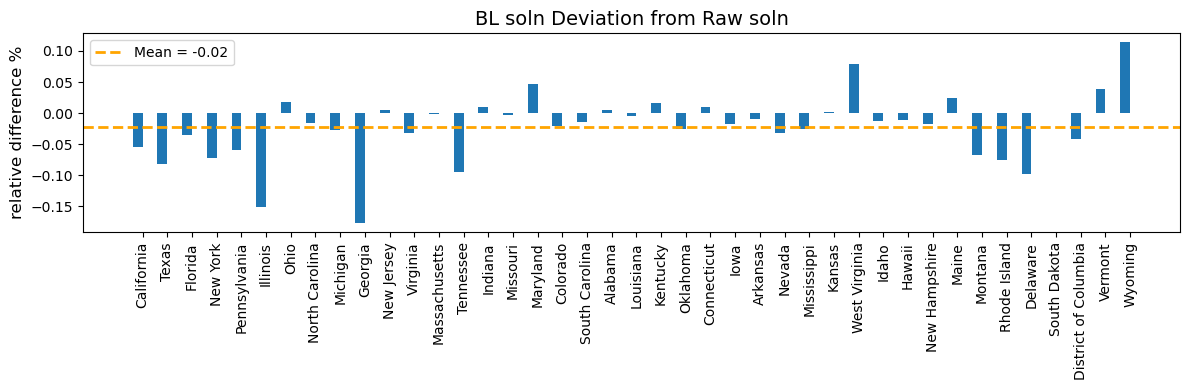

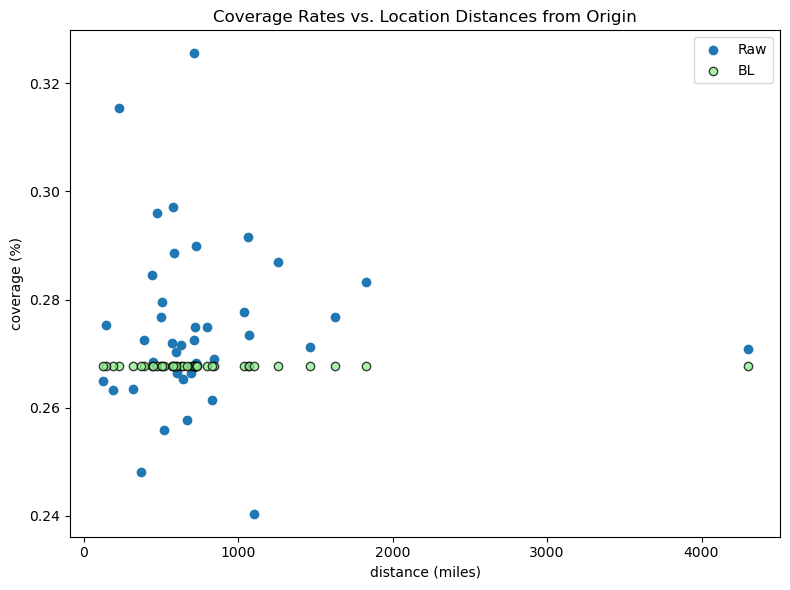

In [210]:
df_sorted = df.sort_values(["Total_1"], ascending=False)

''''''
# Deviation plot
''''''
plt.figure(figsize=(12, 4))
x = np.arange(len(df_sorted))        # positions for states
width = 0.4                          # bar width
fig, ax1 = plt.subplots(figsize=(12, 4))
 # Second y-axis
bars1 = ax1.bar(
    x - width/2,
    deviation,
    width)
mean_dev = np.mean(deviation)
ax1.axhline(
    y=mean_dev,
    linestyle="--",
    color="orange",
    linewidth=2,
    label=f"Mean = {mean_dev:.2f}")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["State"], rotation=90)
# Axis labels
ax1.set_ylabel("relative difference %",fontsize=12)
ax1.set_title(f"BL soln Deviation from Raw soln",fontsize=14)
plt.tight_layout()
plt.legend()
plt.show() 


''''''
# Coverage plot
''''''
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["Distance"],r_raw,label="Raw")
plt.scatter(df_sorted["Distance"],r_sol,label="BL",
            color="lightgreen",edgecolors="black",alpha=0.75)
plt.xlabel("distance (miles)")
plt.ylabel("coverage (%)")
plt.title("Coverage Rates vs. Location Distances from Origin")
plt.tight_layout()
plt.legend()
plt.show()
